In [40]:
import requests
import json
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import contextily as ctx
from adjustText import adjust_text
from ipywidgets import widgets
from ipywidgets import Layout
from ipywidgets import IntProgress, Layout, HBox, Label
from ipywidgets import Button
from functions.widgets import *
from functions.georoc_api import GeoRocAPI
from functions.app import MyApp
from functions.utils import *

In [ ]:
my_app = MyApp()

In [ ]:
display(grid)

In [ ]:
def check_api_connection():
    endpoint = "ping"
    response = my_app.api.api_query(endpoint)

    if response is not None:
        print("Connection to API server successful!\n")
    else:
        print("Failed to connect to API server!\n")
        exit(1)

check_api_connection()

In [ ]:
display(grid2)

In [ ]:
filtered_samples_combined = my_app.api.get_filtered_samples(
    limit=limit_widget.value, 
    offset=offset_widget.value, 
    location1=location1_widget.value,
    location2=location2_widget.value,
    location3=location3_widget.value,
    setting=setting_widget.value,
    latitude=latitude_widget.value,
    longitude=longitude_widget.value,
    rocktype=rocktype_widget.value,
    rockclass=rockclass_widget.value,
    mineral=mineral_widget.value,
    material=material_widget.value,
    inclusiontype=inclusiontype_widget.value,
    sampletech=sampletech_widget.value,
    element=element_widget.value,
    elementtype=elementtype_widget.value,
    value=value_widget.value,
    title=title_widget.value,
    publicationyear=publicationyear_widget.value,
    doi=doi_widget.value,
    firstname=firstname_widget.value,
    lastname=lastname_widget.value,
    agemin=agemin_widget.value,
    agemax=agemax_widget.value,
    geoage=geoage_widget.value,
    geoageprefix=geoageprefix_widget.value,
    lab=lab_widget.value
)

if 'Data' in filtered_samples_combined:
    print("\n")
    for item in filtered_samples_combined['Data']:
        print(str(item))
    print("\n")
else:
    print("No data found or unexpected data structure", "\n")

In [ ]:
if "Data" in filtered_samples_combined and filtered_samples_combined["Data"]:
    sampling_feature_ids = [sample["SampleID"] for sample in filtered_samples_combined["Data"]]
    
    print("\n", "The extracted SampleIDs are:")
    
    # Drucken Sie die SampleIDs in Gruppen von 10 mit einem Zeilenumbruch nach jeder Gruppe
    for i in range(0, len(sampling_feature_ids), 10):
        print(sampling_feature_ids[i:i+10])

    print("\n")
    
else:
    print("No data found or unexpected data structure", "\n")

In [ ]:
# Create an empty DataFrame to store all measurement data
measurement_data = pd.DataFrame()

In [ ]:
progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=len(sampling_feature_ids),
    description='Loading:',
    bar_style='info',
    style={'bar_color': 'maroon'},
    orientation='horizontal'
)

display(progress_bar)

# Iterate over the list of SamplingFeatureIDs
for index, sampling_feature_id in enumerate(sampling_feature_ids):
    # Get the selected keys from the checkboxes
    selected_keys = get_selected_keys(checkboxes)

    # Get the measurement data for the current SamplingFeatureID using the selected keys
    df = get_measurement_data(my_app.api.api_key, sampling_feature_id, selected_keys)

    # Check if the dataframe is not empty and not None
    if df is not None and not df.empty:
        # Add the SampleID to the dataframe
        df['SampleID'] = sampling_feature_id
        
        # Append the dataframe to the measurement_data DataFrame
        measurement_data = measurement_data._append(df, ignore_index=True)

    # Update the progress bar
    progress_bar.value = index + 1

In [ ]:
# Gruppieren und Aggregieren der Messdaten
grouped_data = measurement_data.groupby(['SampleID', 'Item_Name'])['Values'].apply(list).reset_index()

# Pivotieren des DataFrames
pivot_df = grouped_data.pivot(index='SampleID', columns='Item_Name', values='Values')

# Jetzt konvertieren wir die Listen in einzelne Elemente (da es nur einen Eintrag pro Gruppe gibt)
for col in pivot_df.columns:
    pivot_df[col] = pivot_df[col].str[0]

# Extrahieren der 'Longitude', 'Latitude', 'Units', 'Item_Group' und 'SampleName' für jede 'SampleID'
additional_columns_df = measurement_data.drop_duplicates(subset='SampleID')[['SampleID', 'Longitude', 'Latitude', 'Units', 'Item_Group', 'SampleName']]

# Zusammenführen der Daten mit den ursprünglichen Daten, um die zusätzlichen Spalten hinzuzufügen
final_df = pd.merge(pivot_df.reset_index(), additional_columns_df, on='SampleID', how='left')

# Zurücksetzen des Index
final_df.reset_index(drop=True, inplace=True)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

final_df

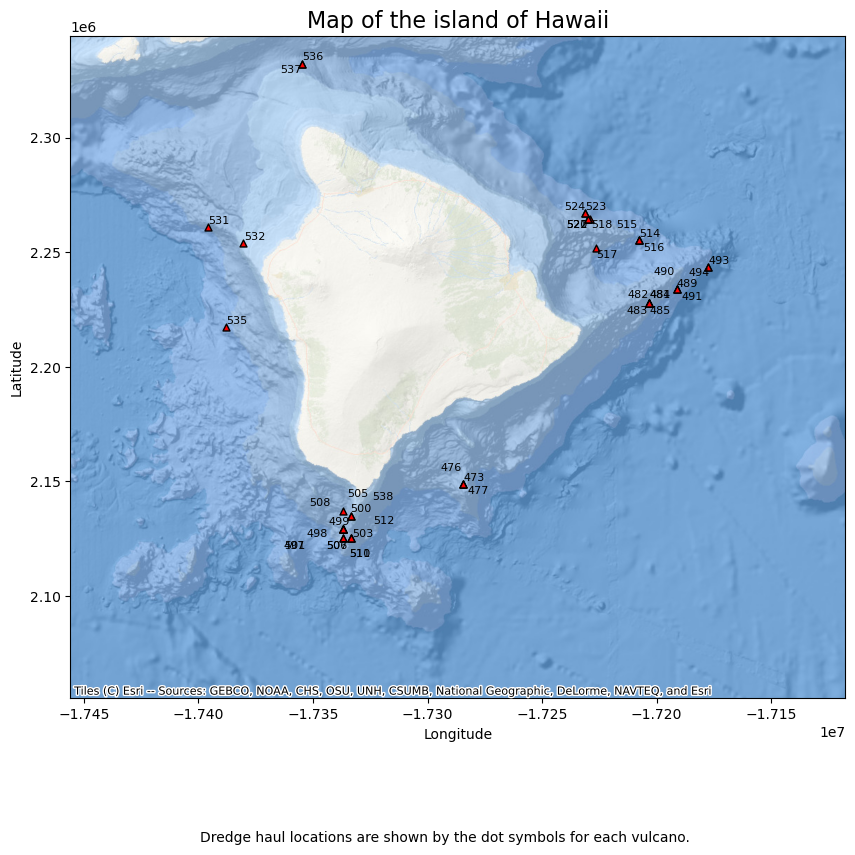

In [35]:
def plot_coordinates_on_map(final_df):
    # Create a geopandas dataframe
    gdf = gpd.GeoDataFrame(
        final_df,
        geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude))
    gdf.crs = 'EPSG:4326'  # Set the initial CRS (Coordinate Reference System) to WGS84

    # Reproject the data to match the CRS used by contextily
    gdf_web_mercator = gdf.to_crs(epsg=3857)

    # Create the base map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot markers on the map with sample IDs
    for _, row in gdf_web_mercator.iterrows():
        ax.scatter(
            row['geometry'].x,
            row['geometry'].y,
            color='red',
            edgecolors='black',
            marker='^',
            s=25
        ) 
        
    # Set the map extent to match the data
    ax.set_xlim(gdf_web_mercator.total_bounds[0] - 60000, gdf_web_mercator.total_bounds[2] + 60000)
    ax.set_ylim(gdf_web_mercator.total_bounds[1] - 70000, gdf_web_mercator.total_bounds[3] + 12000)

    # Add satellite imagery from OpenStreetMap
    ctx.add_basemap(ax, source=ctx.providers.Esri.OceanBasemap, zoom='auto')

    # Add title and axis labels
    ax.set_title('Map of the island of Hawaii', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot sample IDs with adjustText
    texts = []
    for _, row in gdf_web_mercator.iterrows():
        texts.append(
            plt.text(
                row['geometry'].x,
                row['geometry'].y,
                str(row['SampleID']),
                fontsize=8,
                color='black',
                ha='center')
        )

    # Justiere die Textpositionen
    adjust_text(texts)

    description = "Dredge haul locations are shown by the dot symbols for each vulcano."
    plt.figtext(0.5, 0.02, description, ha='center', fontsize=10)

    # Save and show the map
    plt.savefig("plot_hawaii.png")
    plt.show()

# Plot coordinates on the map using the measurement_data DataFrame
plot_coordinates_on_map(final_df)

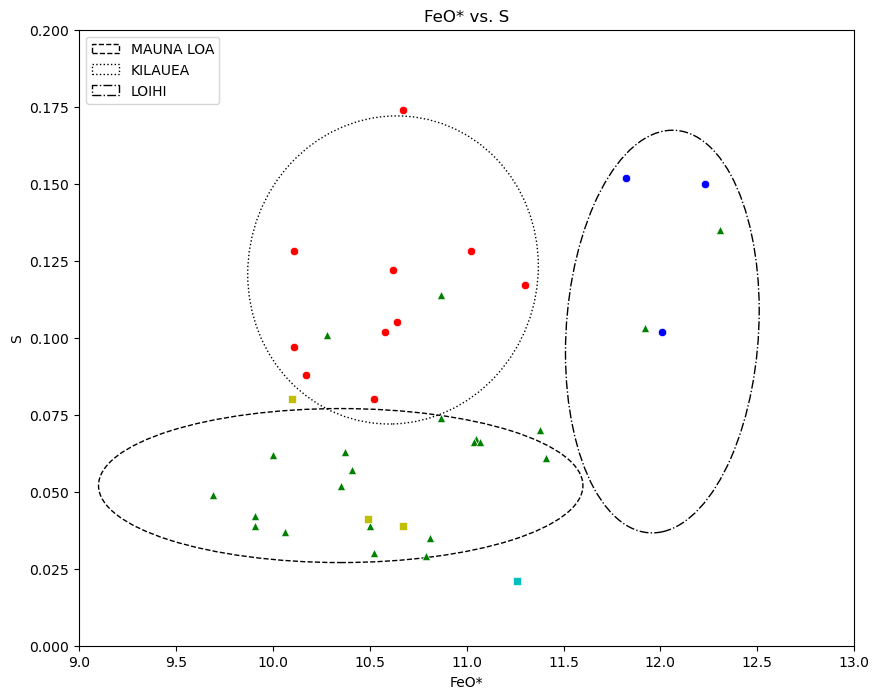

In [43]:
exclude_columns = ['Longitude', 'Latitude', 'Units', 'Item_Group', 'H2O', 'CH4', 'CL', 'CO1', 'CO2', 'D18O', 'DD']
included_columns = [col for col in final_df.columns if col not in exclude_columns]

# Eine Liste von Markern und Farben erstellen
markers = ['o'] * 3 + ['o'] * 10 + ['^'] * 23 + ['s'] * 3 + ['s'] * 3
colors = ['b'] * 3 + ['r'] * 10 + ['g'] * 23 + ['y'] * 3 + ['c'] * 3

# SampleIDs für die Ellipsen auswählen
sampleids_ellipse1 = [511]
sampleids_ellipse2 = [482]
sampleids_ellipse3 = [476]

# Variablen für die Ellipsen außerhalb der Schleife initialisieren
ellipse_center_1 = None
ellipse_width_1 = 0
ellipse_height_1 = 0
ellipse_angle_1 = 0

ellipse_center_2 = None
ellipse_width_2 = 0
ellipse_height_2 = 0
ellipse_angle_2 = 0

ellipse_center_3 = None
ellipse_width_3 = 0
ellipse_height_3 = 0
ellipse_angle_3 = 0

plt.figure(figsize=(10, 8))

for i in range(len(final_df)):
    sns.scatterplot(x=final_df['FEOT'].iloc[i:i+1], y=final_df['S'].iloc[i:i+1],
                    marker=markers[i], color=colors[i])

    sampleid = final_df['SampleID'].iloc[i]
    if sampleid in sampleids_ellipse1:
        if ellipse_center_1 is None:
            ellipse_center_1 = (final_df['FEOT'].iloc[i], final_df['S'].iloc[i])
            ellipse_width_1 = 2.5  # Anpassen der Breite der Ellipse
            ellipse_height_1 = 0.05  # Anpassen der Höhe der Ellipse
            ellipse_angle_1 = 0  # Anpassen des Winkels der Ellipse

        ellipse_1 = Ellipse(ellipse_center_1, ellipse_width_1, ellipse_height_1, angle=ellipse_angle_1, edgecolor='black', facecolor='none', linestyle='dashed')
        plt.gca().add_patch(ellipse_1)

    if sampleid in sampleids_ellipse2:
        if ellipse_center_2 is None:
            ellipse_center_2 = (final_df['FEOT'].iloc[i], final_df['S'].iloc[i])
            ellipse_width_2 = 1.5
            ellipse_height_2 = 0.1
            ellipse_angle_2 = 0.1

        ellipse_2 = Ellipse(ellipse_center_2, ellipse_width_2, ellipse_height_2, angle=ellipse_angle_2, edgecolor='black', facecolor='none', linestyle='dotted')
        plt.gca().add_patch(ellipse_2)

    if sampleid in sampleids_ellipse3:
        if ellipse_center_3 is None:
            ellipse_center_3 = (final_df['FEOT'].iloc[i], final_df['S'].iloc[i])
            ellipse_width_3 = 1.0
            ellipse_height_3 = 0.13
            ellipse_angle_3 = 0.8

        ellipse_3 = Ellipse(ellipse_center_3, ellipse_width_3, ellipse_height_3, angle=ellipse_angle_3, edgecolor='black', facecolor='none', linestyle='dashdot')
        plt.gca().add_patch(ellipse_3)

# Legende hinzufügen
plt.legend(handles=[ellipse_1, ellipse_2, ellipse_3], labels=['MAUNA LOA', 'KILAUEA', 'LOIHI'], loc='upper left')
plt.title("FeO* vs. S")
plt.xlabel("FeO*")
plt.ylabel("S")
plt.xlim(9, 13)
plt.ylim(0, 0.2)
plt.savefig('plot_FEOT_vs_S.png')
plt.show()